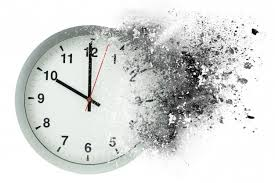

# Table Of Contents
* [Introduction](#intro)
* [Reading Data and Preparation](#rdp)
* [Decomposition of Data](#dcp)
* [Model Fitting](#fit)
* [Conclusion](#conc)

# Introduction
<a id="intro"></a>

When it comes to Auto Regression, the variants of ARIMA dominate the time series market. Can we use machine learning models for the same purpose? We can certainly structure the Time-Series data in a way that it serves our purpose.
Ths notebook focuses on using a new and promising Python library [Sktime](https://github.com/alan-turing-institute/sktime) for multi step ahead forecasts using Tree Ensembles(or any Regression Model).

In [36]:
# ! pip install sktime==0.4.3

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from pylab import rcParams
import math
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

rcParams['figure.figsize'] = 18, 8
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

#-----------------------Imports from Sktime--------------------------

from sktime.transformers.single_series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import (
    TransformedTargetForecaster,
    ReducedRegressionForecaster
)

# Reading Data and Preparation
<a id="rdp"></a>

In [38]:
#------------------------Reading Data from CSV---------------------------

file_name = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
time_dependent_variable = "Count"
time_column = "Datetime"
frmt =  "%Y-%m-%d"
X = "D"
def data(index, file_name, frmt='%Y-%m-%d %H:%M:%S', X= "D"):
    df = pd.read_csv(file_name, parse_dates= True)
    
    df.index = pd.to_datetime(df[time_column],format=frmt) 
    df.index = df.index
    df = df.resample(X).mean()
    
    return df
df = data(index, file_name, frmt,X )
df

,ID,Count
Datetime,,
2012-08-25,11.5,3.166667
2012-08-26,35.5,3.666667
2012-08-27,59.5,2.583333
2012-08-28,83.5,2.416667
2012-08-29,107.5,2.500000
...,...,...
2013-12-27,11747.5,161.166667
2013-12-28,11771.5,128.500000
2013-12-29,11795.5,97.083333


In [39]:
def train_test_split_perc(df, split= .7):
    total_size=len(df)
    train_size=math.floor(split*total_size)  #(70% Dataset)
    train=df.head(train_size)
    test=df.tail(len(df) -train_size)
    return train, test
train, test = train_test_split_perc(df, split= .9)
y_hat = test.copy()

In [40]:
 def plot(method= 'naive'):
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    plt.figure(figsize=(12,8))
    plt.plot(train.index, train[time_dependent_variable], label='Train')
    plt.plot(test.index,test[time_dependent_variable], label='Test')
    plt.plot(y_hat.index,y_hat[method], label= method +' forecast')
    plt.legend(loc='best')
    plt.title(method + ' forecast')
    plt.show()
    rms = sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))
    print('RMSE = '+str(rms))
# plot(method= 'naive' )

In [41]:
def date_features(df):
    
     
    
    df['month'] = df.index.month
    df['year'] = df.index.year
    #df['dayofweek'] = df.index.dt.strftime('%A')
    df['week_day'] = df.index.weekday
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear
    

    return df
date_features(df)

,ID,Count,month,year,week_day,quarter,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2012-08-25,11.5,3.166667,8,2012,5,3,238,25,34
2012-08-26,35.5,3.666667,8,2012,6,3,239,26,34
2012-08-27,59.5,2.583333,8,2012,0,3,240,27,35
2012-08-28,83.5,2.416667,8,2012,1,3,241,28,35
2012-08-29,107.5,2.500000,8,2012,2,3,242,29,35
...,...,...,...,...,...,...,...,...,...
2013-12-27,11747.5,161.166667,12,2013,4,4,361,27,52
2013-12-28,11771.5,128.500000,12,2013,5,4,362,28,52
2013-12-29,11795.5,97.083333,12,2013,6,4,363,29,52


In [42]:
def column_reorder(df):
    df = df[[ col for col in df.columns if col != time_dependent_variable] + [time_dependent_variable]]
    return df
df = column_reorder(df= df)

In [43]:
train, test = train_test_split_perc(df, split= .7)
train_X, train_Y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_Y = test.iloc[:, :-1], test.iloc[:, -1]
train_X.head()

,ID,month,year,week_day,quarter,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2012-08-25,11.5,8,2012,5,3,238,25,34
2012-08-26,35.5,8,2012,6,3,239,26,34
2012-08-27,59.5,8,2012,0,3,240,27,35
2012-08-28,83.5,8,2012,1,3,241,28,35
2012-08-29,107.5,8,2012,2,3,242,29,35


## Preparing the Data

In [44]:
#--------------------------Data Preparation-------------------------

#For the sake of demonstartion, we will train our model on monthly aggregated Sales data of a particular store 

# # Select sales for Store 1 Only.
# store1_agg = df.loc[df['store']==1].groupby(['date'])['sales'].sum()
# store1_agg.index = pd.to_datetime(store1_agg.index)

# #Aggregate the Data on a Monthly basis.
# time_dependent_variable = store1_agg.resample('M').sum()
# time_dependent_variable.head()

In [45]:
#--------------------Visulaize Data on a Time Plot-------------------

# sns.lineplot(
#     data=time_dependent_variable, 
# )
# plt.show()

## Decomposition of Data
<a id="dcp"></a>

The above plot gives us an idea that the time series is seasonal and heteroskedastic. We need to use a **multiplicative decomposition** in such a case, to examine its **seasonal and trend** components and the residuals.

In [46]:
#----------------------Time Series Decomposition---------------------

# seasonal_decompose(time_dependent_variable,model="multiplicative",period=12).plot()
# plt.show()

## Model Fitting
<a id="fit"></a>
Here we explore Sktime's Regression Wrapper for Time Series Forecating.

In [47]:
#--------------------Time Series Train-Test split-------------------

# time_dependent_variable.index = time_dependent_variable.index.to_period('M') 
# train_Y, test_Y = temporal_train_test_split(time_dependent_variable, test_size=0.2)
train_Y

Datetime
2012-08-25      3.166667
2012-08-26      3.666667
2012-08-27      2.583333
2012-08-28      2.416667
2012-08-29      2.500000
                 ...    
2013-07-31     89.916667
2013-08-01    103.833333
2013-08-02     74.583333
2013-08-03     54.166667
2013-08-04     38.833333
Freq: D, Name: Count, Length: 345, dtype: float64

### Fitting a Detrender
We fit a **Linear Trend**  detector in this step, we will use this to forecast the future trend. 

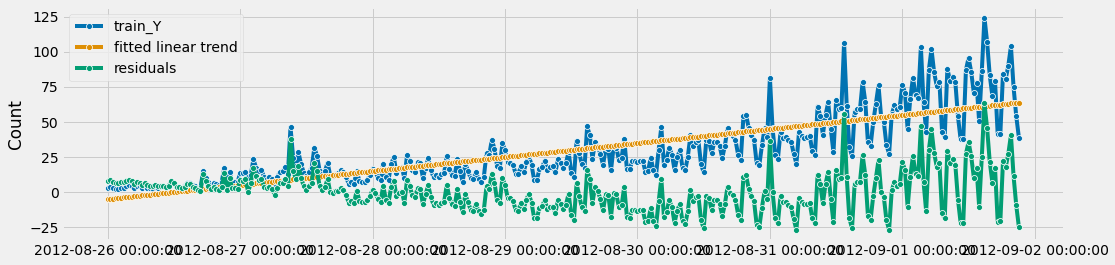

In [48]:
#--------------------------Detrender-----------------------------

#degree=1 for Linear
forecaster = PolynomialTrendForecaster(degree=1) 
transformer = Detrender(forecaster=forecaster)

#Get the residuals after fitting a linear trend
y_resid = transformer.fit_transform(train_Y)

# Internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(train_Y))  # in-sample forecasting horizon
y_pred = forecaster.fit(train_Y).predict(fh=fh_ins)

plot_series(train_Y, y_pred, y_resid, labels=["train_Y", "fitted linear trend", "residuals"]);

### Fitting a Deseasonalizer
We fit a Deseasonalizer in this step, we will use this to forecast the seasonality. We extract the Monthly Seasonality in this step(period=12)

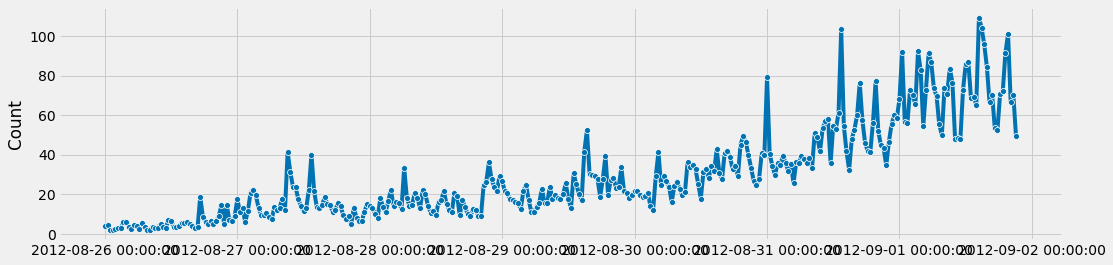

In [49]:
#--------------------------Detrender-----------------------------

#Multiplicative Deseasonalizer, period = 12(for Monthly Data)
deseasonalizer = Deseasonalizer(model="multiplicative", sp=7)
plot_series(deseasonalizer.fit_transform(train_Y))
seasonal = deseasonalizer.fit_transform(train_Y)

### Fitting an Autoregressor.
After removing the Linear Trend and Seasonal Components, we use an Autoregressor to regress on its previous values and forecast. These 3 sequential steps can be conveniently pipelined using **TransformedTargetForecaster**. So it abstracts the steps of first forecasting Seasonality, Trend, the forecasts of the Autoregressor, and then finally combining the three components to get a single forecast! To generate the Prediction Intervals we create three such abstractions.

In [50]:
#----------------------------Create Pipeline--------------------

def get_transformed_target_forecaster(alpha,params):
    
    #Initialize Light GBM Regressor 
    
    regressor = lgb.LGBMRegressor(alpha = alpha,**params)

    #-----------------------Forecaster Pipeline-----------------
    
    #1.Separate the Seasonal Component.
    #2.Fit a forecaster for the trend.
    #3.Fit a Autoregressor to the resdiual(autoregressing on two historic values).
    
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
            (
                # Recursive strategy for Multi-Step Ahead Forecast.
                # Auto Regress on two previous values
                "forecast",
                ReducedRegressionForecaster(
                    regressor=regressor, window_length=4, strategy="recursive",
                ),
            ),
        ]
    )
    return forecaster

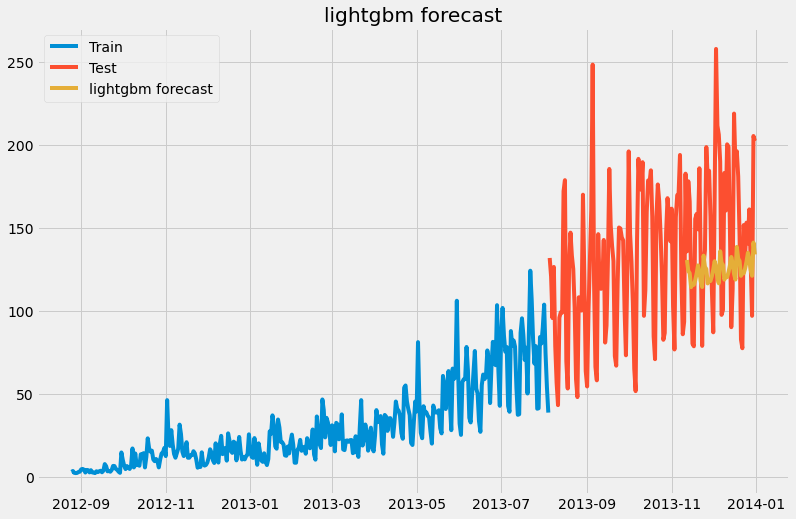

ValueError: Found input variables with inconsistent numbers of samples: [149, 50]

In [51]:
#-------------------Fitting an Auto Regressive Light-GBM-----------------

#Setting Quantile Regression Hyper-parameter.
params = {
    'objective':'quantile'
}

#A 10 percent and 90 percent prediction interval(0.1,0.9 respectively).
quantiles = [.1, .5, .9] #Hyper-parameter "alpha" in Light GBM

#Capture forecasts for 10th/median/90th quantile, respectively.
forecasts = []

#Iterate for each quantile.
for alpha in quantiles:
    
    forecaster = get_transformed_target_forecaster(alpha,params)
    
    #Initialize ForecastingHorizon class to specify the horizon of forecast
    fh = ForecastingHorizon(test_Y.index, is_relative=False)
    
    #Fit on Training data.
    forecaster.fit(train_Y)
    
    #Forecast the values.
    y_hat["lightgbm"] = forecaster.predict(fh)
    
#     #List of forecasts made for each quantile.
#     y_pred.index.name="date"
#     y_pred.name=f"predicted_sales_q_{alpha}"
#     forecasts.append(y_pred)
    
plot(method="lightgbm")
    
# #Append the actual data for plotting.
# df[time_dependent_variable].index.name = "date"
# df[time_dependent_variable.name = "original"
# forecasts.append(df.time_dependent_variable)

In [ ]:
# #-------------------Final Plotting of Forecasts------------------

# plot_data = pd.melt(pd.concat(forecasts,axis=1).reset_index(), id_vars=['date'],\
#         value_vars=['predicted_sales_q_0.1', 'predicted_sales_q_0.5',
#                    'predicted_sales_q_0.9','original'])
# plot_data['date'] = pd.to_datetime(plot_data['date'].astype(str).to_numpy())
# plot_data['if_original'] = plot_data['variable'].apply(
#     lambda r:'original' if r=='original' else 'predicted' 
# )
# sns.lineplot(data = plot_data,
#         x='date',
#         y='value',
#         hue='if_original',
#              style="if_original",
#         markers=['o','o'],
# )
# plt.show()

## Conclusion
<a id="conc"></a>
Will create more notebooks demonstrating other features from this Library.Thanks!